# import libraries

In [11]:
library(data.table)
library(tidygraph)
library(ggraph)
library(dplyr)


# import TE GTF file

In [5]:
# import GTF file
te_dt = fread('/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf')
setnames(te_dt, c('chr', 'rmsk', 'exon', 'start', 'end', 'width', 'strand', 'score', 'info'))

# extract class, family, gene, and transcript IDs
te_dt[, transcript_id := sub('gene_id "(.*)"; transcript_id "(.*)"; family_id "(.*)"; class_id "(.*)";', '\\2', info)]
te_dt[, gene_id       := sub('gene_id "(.*)"; transcript_id "(.*)"; family_id "(.*)"; class_id "(.*)";', '\\1', info)]
te_dt[, family_id     := sub('gene_id "(.*)"; transcript_id "(.*)"; family_id "(.*)"; class_id "(.*)";', '\\3', info)]
te_dt[, class_id      := sub('gene_id "(.*)"; transcript_id "(.*)"; family_id "(.*)"; class_id "(.*)";', '\\4', info)]

head(te_dt)


chr,rmsk,exon,start,end,width,strand,score,info,transcript_id,gene_id,family_id,class_id
<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1,UCSC_rmsk,exon,2710,4402,5119,-,.,"gene_id ""TAR1""; transcript_id ""TAR1_dup164""; family_id ""subtelo""; class_id ""Satellite"";",TAR1_dup164,TAR1,subtelo,Satellite
chr1,UCSC_rmsk,exon,4083,4533,962,-,.,"gene_id ""LTR60B""; transcript_id ""LTR60B_dup190""; family_id ""ERV1""; class_id ""LTR"";",LTR60B_dup190,LTR60B,ERV1,LTR
chr1,UCSC_rmsk,exon,4534,4660,505,-,.,"gene_id ""LTR60B""; transcript_id ""LTR60B_dup191""; family_id ""ERV1""; class_id ""LTR"";",LTR60B_dup191,LTR60B,ERV1,LTR
chr1,UCSC_rmsk,exon,4664,5263,1304,+,.,"gene_id ""L1MC3""; transcript_id ""L1MC3_dup5932""; family_id ""L1""; class_id ""LINE"";",L1MC3_dup5932,L1MC3,L1,LINE
chr1,UCSC_rmsk,exon,5275,5528,1403,+,.,"gene_id ""MER34C_v""; transcript_id ""MER34C_v_dup375""; family_id ""ERV1""; class_id ""LTR"";",MER34C_v_dup375,MER34C_v,ERV1,LTR
chr1,UCSC_rmsk,exon,5529,5686,3544,+,.,"gene_id ""L1MC3""; transcript_id ""L1MC3_dup5932""; family_id ""L1""; class_id ""LINE"";",L1MC3_dup5932,L1MC3,L1,LINE


In [6]:
graph_dt = copy(te_dt)

# when class and family were the same, add '_F' to the end of family IDs
graph_dt[class_id == family_id, family_id := paste0(family_id, '_F')]
# when family were the same as gene IDs, add '_G' to the end of gene IDs
graph_dt[family_id == gene_id, gene_id := paste0(gene_id, '_G')]
# when gene is the same as transcript IDs, add '_Tx' to the end of transcript IDs
graph_dt[gene_id == transcript_id, transcript_id := paste0(transcript_id, '_Tx')]

# when the above family name changed in class IDs ==> family IDs, 
# then change these family IDs in family IDs ==>  gene IDs
graph_dt[family_id %in% graph_dt$class_id, family_id := paste0(family_id, '_F')]
# similary for the changed gene IDs
graph_dt[gene_id %in% graph_dt$family_id, gene_id := paste0(family_id, '_G')]
# similary for the changed Tx IDs
graph_dt[transcript_id %in% graph_dt$gene_id, transcript_id := paste0(family_id, '_Tx')]


In [12]:
# create level 1, adding a pseudo 'TE' element
# this TE connected to 11 class IDs
tmp1 = graph_dt[!duplicated(class_id), .(class_id)]
setnames(tmp1, 1, 'to')
tmp1[, from := 'TE'] 
tmp1 = relocate(tmp1, 2)
tmp1$lvl = 'lvl1'

# add level two from class to family  IDs
tmp2 = graph_dt[!duplicated(family_id), .(class_id, family_id)]
setnames(tmp2, c('from', 'to'))
tmp2$lvl = 'lvl2'

# add level three from family to gene IDs
tmp3 = graph_dt[!duplicated(gene_id), .(family_id, gene_id)]
setnames(tmp3, c('from', 'to'))
tmp3$lvl = 'lvl3'

# add level four from gene to transcript IDs
tmp4 = graph_dt[!duplicated(transcript_id), .(gene_id, transcript_id)]
setnames(tmp4, c('from', 'to'))
tmp4$lvl = 'lvl4'

# combine the four level together
graph_dt_2 = rbindlist(list(tmp1, tmp2, tmp3, tmp4), use.names=TRUE )
graph_dt_2[, from_ori := from]
graph_dt_2[, to_ori := to]

graph_dt = copy(graph_dt_2)
remove(graph_dt_2)


In [13]:
head(graph_dt)

from,to,lvl,from_ori,to_ori
<chr>,<chr>,<chr>,<chr>,<chr>
TE,Satellite,lvl1,TE,Satellite
TE,LTR,lvl1,TE,LTR
TE,LINE,lvl1,TE,LINE
TE,SINE,lvl1,TE,SINE
TE,DNA,lvl1,TE,DNA
TE,Unknown,lvl1,TE,Unknown


# A test plot

Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”


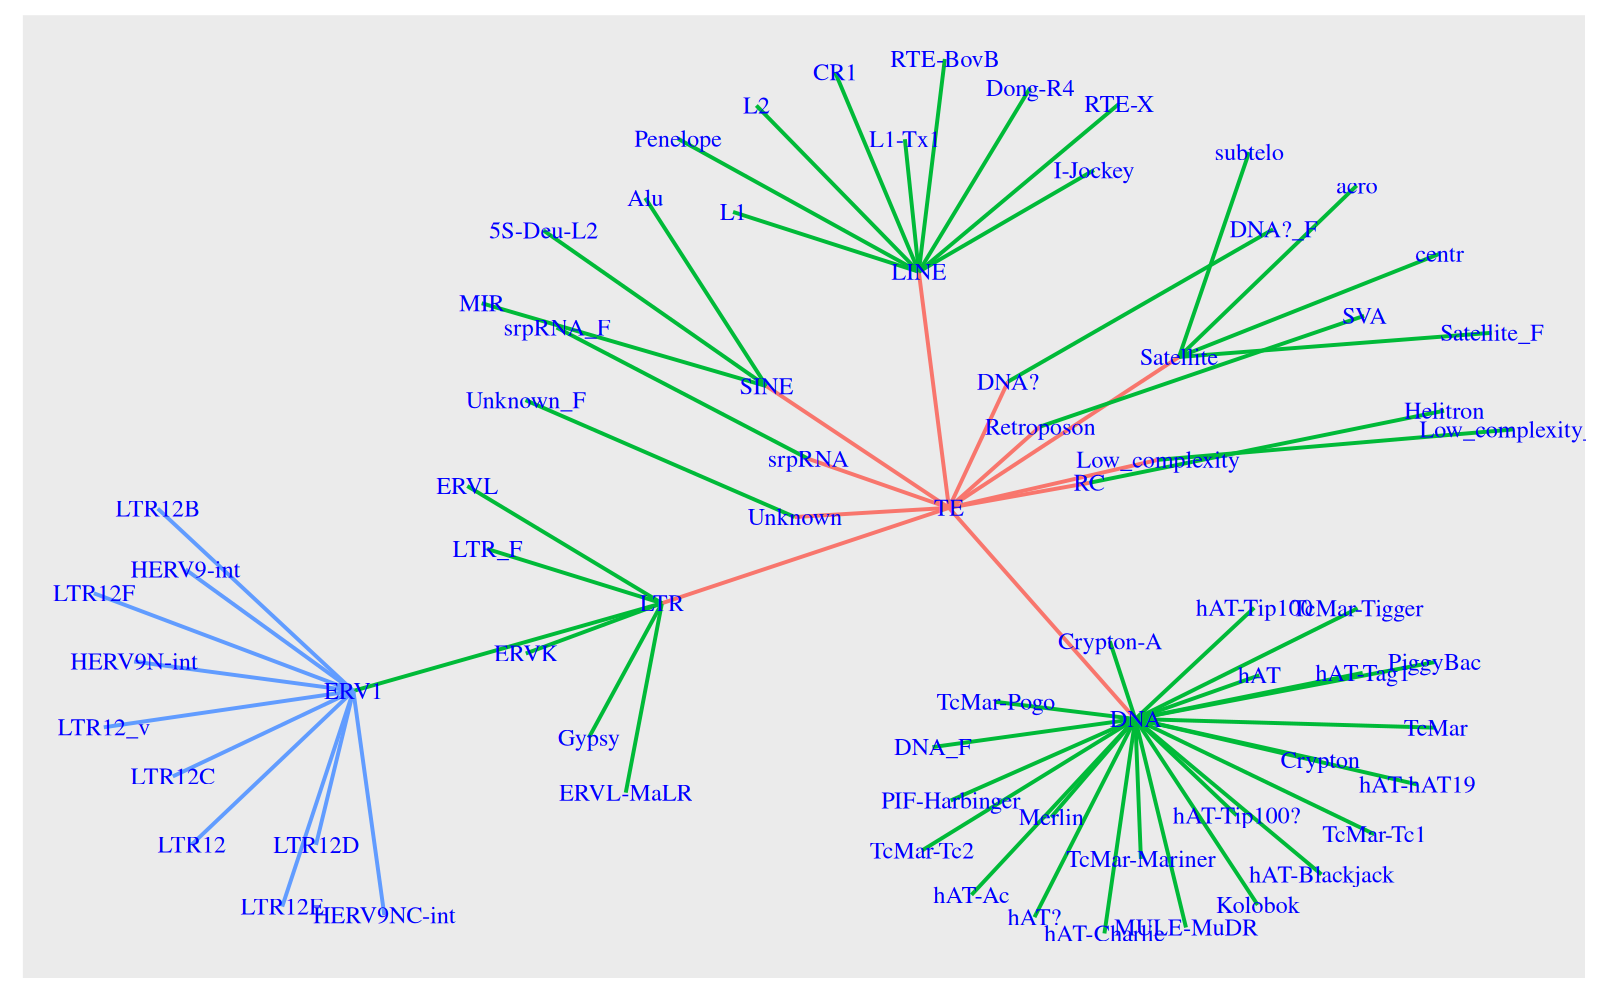

In [14]:
# select level 1 and 2 
plotdat0 = graph_dt[lvl %in% c('lvl1', 'lvl2'), ] 
# select interested ones from level 3
plotdat1 = graph_dt[grepl('HERV9', to) & lvl == 'lvl3', ] 
plotdat2 = graph_dt[grepl('LTR12', to) & lvl == 'lvl3', ] 

plotdat = rbind(plotdat0, plotdat1, plotdat2)
plotdat = as_tbl_graph(plotdat)

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)
ggraph(plotdat, layout = 'stress') +  geom_edge_link(aes(colour = factor(lvl))) +  #geom_node_point() + 
  geom_node_text(aes(label = name),  colour = 'blue', size=3, show.legend = FALSE, family = "serif") + theme(legend.position = "none")
